In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from diffusers import StableDiffusionPipeline, DDIMScheduler

# 1. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/stable-diffusion-v1-4"

print(f"Loading model: {model_id}...")
# Use float32 to match other scripts in the repo
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.to(device)
pipe.set_progress_bar_config(disable=True)
print("Model loaded.")

Loading model: CompVis/stable-diffusion-v1-4...


/home/gpuadmin/cssin/cond_Jacobian/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded.


In [2]:
# 2. Load Prompts
def load_prompts(filepath):
    with open(filepath, 'r') as f:
        prompts = [line.strip() for line in f.readlines() if line.strip()]
    return prompts

mem_prompts_file = "prompts/sd1_mem.txt"
nmem_prompts_file = "prompts/sd1_nmem.txt"

mem_prompts = load_prompts(mem_prompts_file)
nmem_prompts = load_prompts(nmem_prompts_file)

print(f"Loaded {len(mem_prompts)} memorized prompts.")
print(f"Loaded {len(nmem_prompts)} non-memorized prompts.")

Loaded 500 memorized prompts.
Loaded 500 non-memorized prompts.


Generating 5 images for Memorized prompts...


Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
Token indices sequence length is longer than the specified maximum sequence length for this model (119 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['dini, highly detailed, unreal engine, trending on artstation, octane render, 4 k, 8 k, hd, oil on canvas by elena zhurikhina and goro fujita and charlie bowater']


Generating 5 images for Non-Memorized prompts...


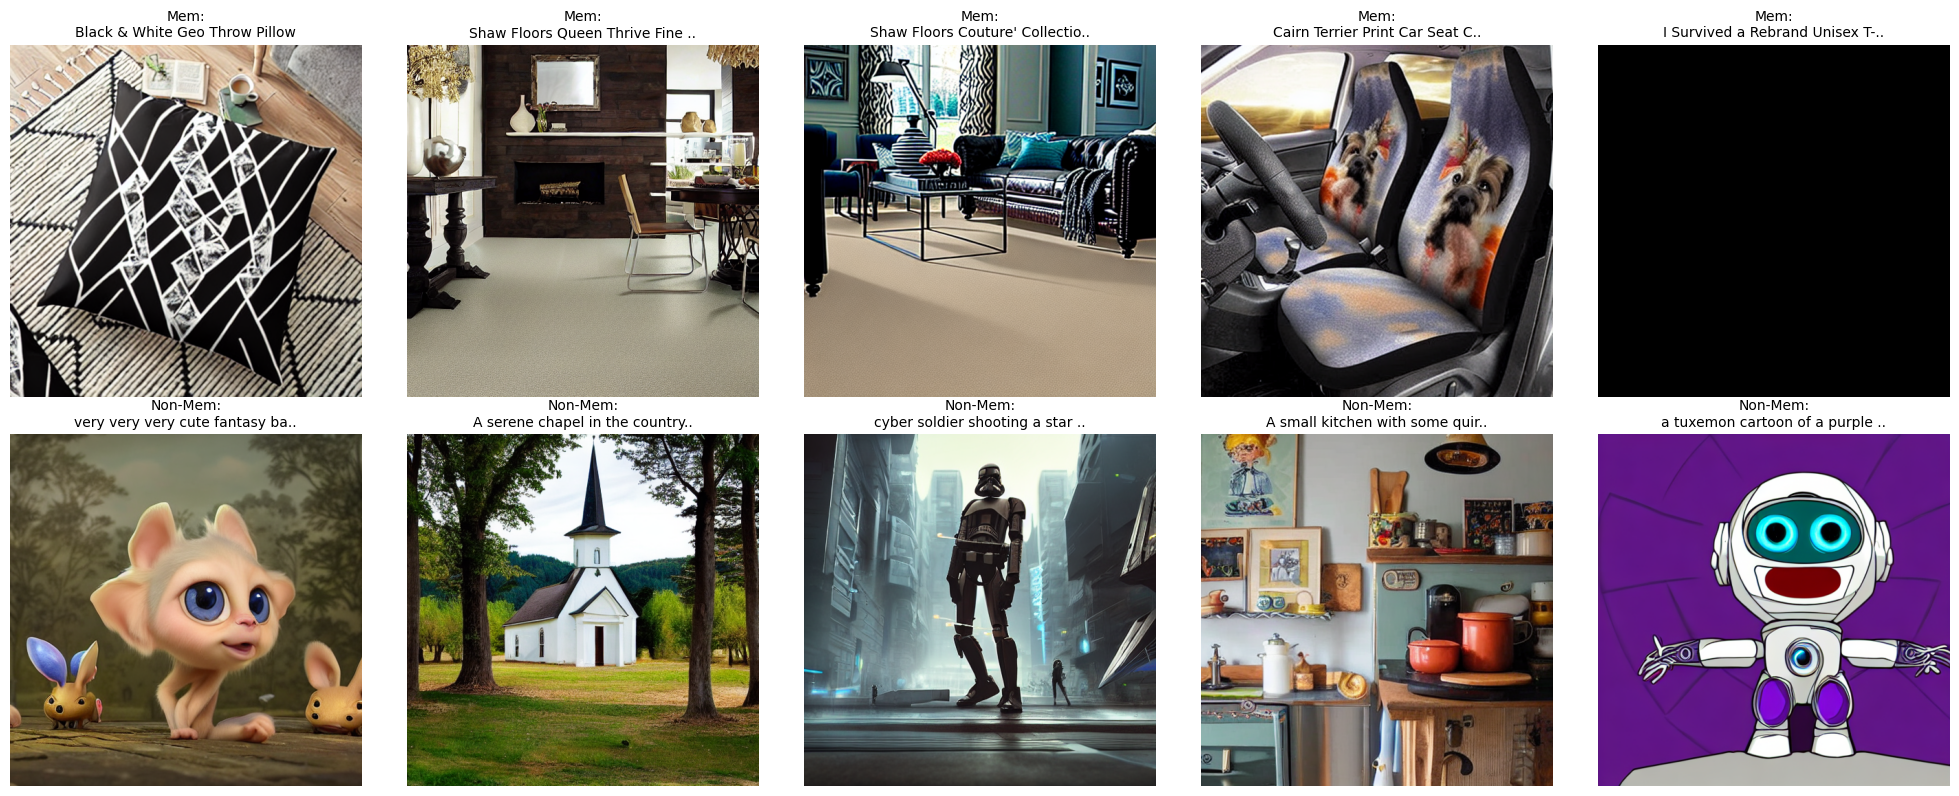

In [3]:
# 3. Select n random prompts and Generate
n = 5  # Number of prompts to select

# Randomly sample Prompts
selected_mem = random.sample(mem_prompts, n)
selected_nmem = random.sample(nmem_prompts, n)

def generate_images(prompts, pipeline, seed=42):
    images = []
    # Use a generator for reproducibility
    generator = torch.Generator(device=device).manual_seed(seed)
    for p in prompts:
        # The user wants to see what happens inside this pipeline call.
        # See the next cell for a breakdown.
        img = pipeline(p, num_inference_steps=50, generator=generator).images[0]
        images.append(img)
    return images

print(f"Generating {n} images for Memorized prompts...")
mem_images = generate_images(selected_mem, pipe)

print(f"Generating {n} images for Non-Memorized prompts...")
nmem_images = generate_images(selected_nmem, pipe)

# 4. Visualize Results
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

# Plot Memorized
for i, (img, prompt) in enumerate(zip(mem_images, selected_mem)):
    ax = axes[0, i] if n > 1 else axes[0]
    ax.imshow(img)
    ax.axis("off")
    short_prompt = (prompt[:30] + '..') if len(prompt) > 30 else prompt
    ax.set_title(f"Mem:\n{short_prompt}", fontsize=10)

# Plot Non-Memorized
for i, (img, prompt) in enumerate(zip(nmem_images, selected_nmem)):
    ax = axes[1, i] if n > 1 else axes[1]
    ax.imshow(img)
    ax.axis("off")
    short_prompt = (prompt[:30] + '..') if len(prompt) > 30 else prompt
    ax.set_title(f"Non-Mem:\n{short_prompt}", fontsize=10)

plt.tight_layout()
plt.show()

Inspecting generation for: Army of Christmas Nutcrackers Barely There iPhone 6 Case
Starting denoising loop...


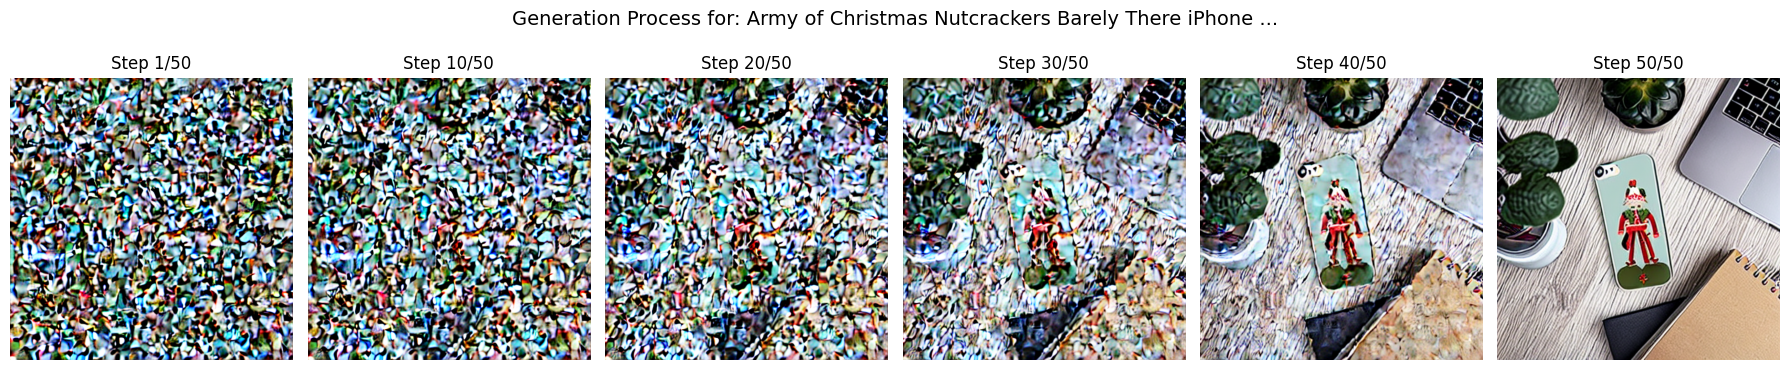

In [3]:
# 5. Step-by-Step Pipeline Inspection
# This cell manually deconstructs the pipeline generation process to visualize intermediate steps.
n = 5
selected_mem = random.sample(mem_prompts, n)
selected_nmem = random.sample(nmem_prompts, n)
target_prompt = selected_mem[0]  # Pick the first memorized prompt for inspection
print(f"Inspecting generation for: {target_prompt}")

# (A) Encode Prompt
# Get text embeddings
text_inputs = pipe.tokenizer(
    [target_prompt], padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(text_inputs.input_ids.to(device))[0]

# Get unconditional embeddings (for Classifier-Free Guidance)
max_length = text_inputs.input_ids.shape[-1]
uncond_input = pipe.tokenizer(
    [""], padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

# Concatenate for batch processing (batch_size=2: [uncond, cond])
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# (B) Initialize Latents (Noise)
generator = torch.Generator(device=device).manual_seed(42)
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 64, 64),
    generator=generator,
    device=device,
    dtype=pipe.unet.dtype
)

# (C) Set Scheduler
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps

# (D) Denoising Loop
intermediates = []
print("Starting denoising loop...")

for i, t in enumerate(timesteps):
    # 1. Expand latents for guidance (double the batch for uncond + cond)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 2. Predict Noise Residual
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # 3. Perform Guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guidance_scale = 7.5
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 4. Compute Previous Noisy Sample x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # 5. Capture Intermediate Result (Decode to Image)
    # Decoding is expensive, so we do it every 10 steps or at specific checkpoints
    if i == 0 or (i + 1) % 10 == 0:
        with torch.no_grad():
            # Scale latents before decoding (SD v1.4 specific constant)
            latents_to_viz = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents_to_viz).sample
            # Rescale to [0, 1]
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            intermediates.append((i+1, image))

# 6. Visualize Steps
num_viz = len(intermediates)
fig, axes = plt.subplots(1, num_viz, figsize=(3*num_viz, 4))
plt.suptitle(f"Generation Process for: {target_prompt[:50]}...", fontsize=14)

for idx, (step, img) in enumerate(intermediates):
    if num_viz > 1:
        ax = axes[idx]
    else:
        ax = axes
    ax.imshow(img)
    ax.set_title(f"Step {step}/50")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch
from tqdm.auto import tqdm


def find_robust_point_batch(unet, 
                            prompt_embeds, 
                            latents, 
                            t, 
                            epsilon=1e-2, 
                            steps=10, 
                            step_size=1e-3, 
                            eps_sam = 1e-4,
                            eps_pi = 1e-4):
    """
    x_origin: [1, 77, 768] 형태의 입력 텐서
    epsilon: x의 의미가 변하지 않는다고 허용하는 최대 거리 (L2 norm)
    """
    
    # 1. 입력 텐서 복제 및 Gradient 설정
    # detach()로 기존 그래프와 분리하고, requires_grad=True로 설정하여 최적화 준비
    x = prompt_embeds.clone().detach().requires_grad_(True)
    
    # x를 업데이트할 Optimizer 정의
    optimizer = torch.optim.SGD([x], lr=step_size)

    for i in tqdm(range(steps), desc="Finding Robust Point"):
        # --- [Step 1] Power Iteration으로 가장 민감한 입력 방향(v) 찾기 ---
        # 목표: J^T * J 의 가장 큰 고유벡터(Right Singular Vector) v 찾기
        
        # 1-1. 랜덤 벡터 v 초기화 (Input Shape: [1, 77, 768])
        v = torch.randn_like(x)
        v = v / (torch.norm(v) + 1e-8)
        
        # 1-2. Power Iteration (1회 수행으로 근사)
        # v (Input Space) -> u = J*v (Output Space) -> v_new = J^T*u (Input Space)
        
        # (A) J*v 계산: Finite Difference 이용 (Forward AD 대용)
        # autograd.grad로 J*v를 직접 구하기 까다로우므로, 작은 섭동(epsilon_pi)을 주어 근사합니다.
        # 이 방식은 모델의 출력 형태(Output Shape)가 무엇이든 상관없이 작동합니다.
        with torch.no_grad():
            
            output_curr = unet(latents, t, encoder_hidden_states=x).sample
            output_pert = unet(latents, t, encoder_hidden_states=x + eps_pi * v).sample
            # u_approx는 J * v (출력 공간에서의 변화량)
            u_approx = (output_pert - output_curr) / eps_pi 
            
        # (B) J^T * u 계산: Vector-Jacobian Product (VJP)
        # PyTorch의 autograd.grad는 기본적으로 VJP를 계산합니다.
        # x에 대한 기울기를 구하면 J^T * u_approx 가 됩니다.
        
        output = unet(latents, t, encoder_hidden_states=x).sample # 그래프 생성을 위해 다시 호출
        
        # grad_outputs에 위에서 구한 u_approx를 넣어줍니다.
        # 결과값 v_grad는 입력 공간([1, 77, 768])의 벡터가 됩니다.
        v_grad = torch.autograd.grad(output, x, grad_outputs=u_approx, create_graph=True)[0]
        
        # 정규화하여 가장 민감한 방향 v 확정
        v_optimal = v_grad / (torch.norm(v_grad) + 1e-8)
        
        # v_optimal은 Gradient 계산 그래프에 포함되지 않도록 끊어줍니다. (방향만 필요)
        v_optimal = v_optimal.detach()


        # --- [Step 2] Sensitivity Minimization ---
        # x 위치에서 v_optimal 방향으로의 변화량(Jacobian Norm)을 줄이는 Loss 계산
        
        # 다시 한번 그래프를 생성하여 Loss를 x에 대해 미분할 수 있게 합니다.
        output_for_loss = unet(latents, t, encoder_hidden_states=x).sample
        
        # J * v_optimal (이번엔 Finite Diff 대신 정확한 미분 사용 가능하면 좋지만, 
        # Double Backprop 메모리 절약을 위해 여기서는 다시 Finite Diff를 쓰거나,
        # 혹은 J^T*u 의 크기를 줄이는 방식을 쓸 수 있습니다.
        # 가장 직관적인 SAM 방식(Finite Difference)을 적용합니다.)
        
        # "가장 나쁜 방향(v_optimal)으로 살짝 밀었을 때, 출력이 덜 변하게 하라"
        
        x_perturbed = x + eps_sam * v_optimal
        y_perturbed = unet(latents, t, encoder_hidden_states=x_perturbed).sample
        y_original = unet(latents, t, encoder_hidden_states=x).sample
        
        # Consistency Loss: ||f(x+ev) - f(x)||
        # 이 Loss를 줄이면 해당 방향의 Jacobian 크기가 줄어듭니다.
        loss = torch.norm(y_perturbed - y_original)

        # --- [Step 3] x 업데이트 (Gradient Descent) ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- [Step 4] Projection (의미 보존) ---
        # x가 x_origin에서 epsilon 반경 밖으로 나가지 않도록 투영
        with torch.no_grad():
            diff = x - prompt_embeds
            # Batch=1 이므로 전체에 대해 norm을 구합니다.
            norm = torch.norm(diff)
            if norm > epsilon:
                # 원본 위치 방향으로 epsilon 거리만큼만 이동한 위치로 강제 조정
                x.data = prompt_embeds + diff * (epsilon / norm)

        print(f'변화량 : {torch.norm(x - prompt_embeds)}')
        print(f'상대적인 변화율 : {torch.norm(x - prompt_embeds) / torch.norm(prompt_embeds) * 100}%')
            
    return x.detach().requires_grad_(False)

In [31]:
def compute_jacobian_norm_batched(unet, latents, t, prompt_embeds, num_projections=1):
    """
    Batched Hutchinson estimator for ||J||_F.
    Returns a tensor of shape (batch_size,) containing the Jacobian norm for each sample.
    """
    prompt_embeds = prompt_embeds.detach()
    latents = latents.detach()
    
    batch_size = latents.shape[0]
    
    with torch.enable_grad():
        prompt_embeds.requires_grad_(True)
        # Forward pass
        noise_pred = unet(latents, t, encoder_hidden_states=prompt_embeds).sample
        
        sq_norm_sum = torch.zeros(batch_size, device=latents.device)
        
        for k in range(num_projections):
            # Random probe v
            v = torch.randn_like(noise_pred)
            
            v_dot_eps_sum = torch.sum(noise_pred * v)
            
            retain = (k < num_projections - 1)
            grads = torch.autograd.grad(v_dot_eps_sum, prompt_embeds, retain_graph=retain, create_graph=False)[0]
            
            # Squared norm per sample
            grads_sq_flat = grads.view(batch_size, -1).pow(2)
            sample_sq_norms = grads_sq_flat.sum(dim=1) # [B]
            
            sq_norm_sum += sample_sq_norms.detach()
            
        est_frob_sq = sq_norm_sum / max(1, float(num_projections))
        return est_frob_sq.sqrt() # [B]

Inspecting generation for: Army of Christmas Nutcrackers Barely There iPhone 6 Case


Finding Robust Point:   0%|          | 0/100 [00:00<?, ?it/s]

변화량 : 0.00781315565109253
상대적인 변화율 : 0.0031578456982970238%
Starting denoising loop...


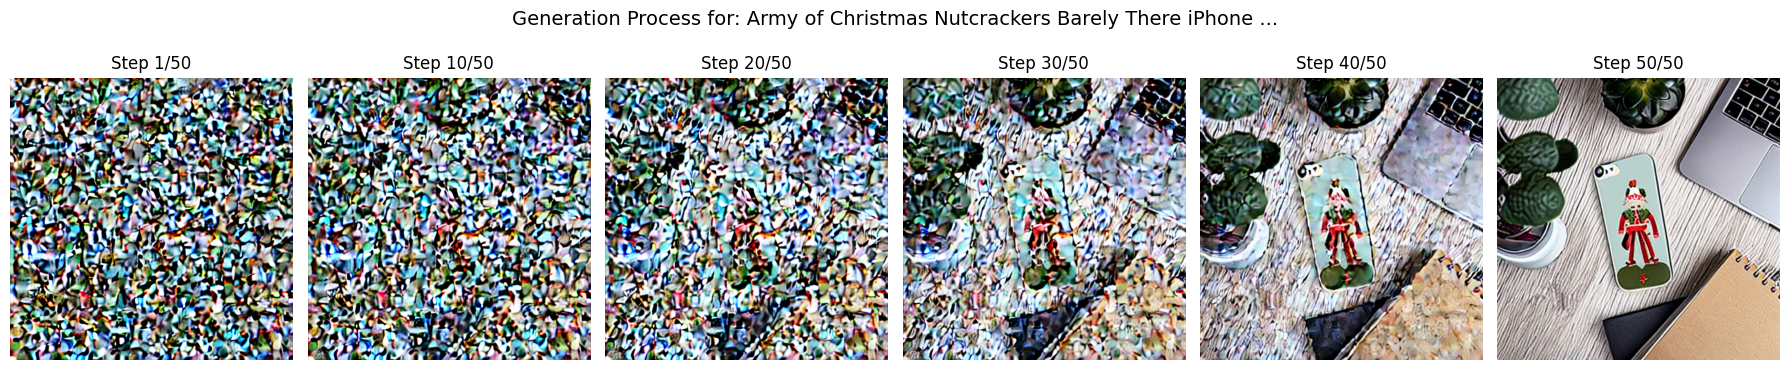

In [ ]:
# 5. Step-by-Step Pipeline Inspection
# This cell manually deconstructs the pipeline generation process to visualize intermediate steps.

target_prompt = selected_mem[0]  # Pick the first memorized prompt for inspection
print(f"Inspecting generation for: {target_prompt}")

# (A) Encode Prompt
# Get text embeddings
text_inputs = pipe.tokenizer(
    [target_prompt], padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    cond_embeddings = pipe.text_encoder(text_inputs.input_ids.to(device))[0]

# Get unconditional embeddings (for Classifier-Free Guidance)
max_length = text_inputs.input_ids.shape[-1]
uncond_input = pipe.tokenizer(
    [""], padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings_origin = torch.cat([uncond_embeddings, cond_embeddings])

# (B) Initialize Latents (Noise)
generator = torch.Generator(device=device).manual_seed(42)
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 64, 64),
    generator=generator,
    device=device,
    dtype=pipe.unet.dtype
)

# (C) Set Scheduler
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps

initial_timestep = timesteps[0]

latent_for_PGD = pipe.scheduler.scale_model_input(latents, initial_timestep)

PGD_prompts_embeddings = find_robust_point_batch(pipe.unet,  
                                                prompt_embeds = cond_embeddings,
                                                latents = latent_for_PGD, 
                                                t = initial_timestep,
                                                epsilon=1e-2, 
                                                steps=100, 
                                                step_size=5e-3, 
                                                eps_sam = 3e-3,
                                                eps_pi = 1e-4)


text_embeddings = torch.cat([uncond_embeddings, PGD_prompts_embeddings])

# (D) Denoising Loop
intermediates = []
print("Starting denoising loop...")

for i, t in enumerate(timesteps):
    # 1. Expand latents for guidance (double the batch for uncond + cond)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 2. Predict Noise Residual
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # 3. Perform Guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guidance_scale = 7.5
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 4. Compute Previous Noisy Sample x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # 5. Capture Intermediate Result (Decode to Image)
    # Decoding is expensive, so we do it every 10 steps or at specific checkpoints
    if i == 0 or (i + 1) % 10 == 0:
        with torch.no_grad():
            # Scale latents before decoding (SD v1.4 specific constant)
            latents_to_viz = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents_to_viz).sample
            # Rescale to [0, 1]
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            intermediates.append((i+1, image))

# 6. Visualize Steps
num_viz = len(intermediates)
fig, axes = plt.subplots(1, num_viz, figsize=(3*num_viz, 4))
plt.suptitle(f"Generation Process for: {target_prompt[:50]}...", fontsize=14)

for idx, (step, img) in enumerate(intermediates):
    if num_viz > 1:
        ax = axes[idx]
    else:
        ax = axes
    ax.imshow(img)
    ax.set_title(f"Step {step}/50")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
j_norms_PGD = compute_jacobian_norm_batched(pipe.unet, latent_for_PGD, initial_timestep, PGD_prompts_embeddings, num_projections=10)
j_norms = compute_jacobian_norm_batched(pipe.unet, latent_for_PGD, initial_timestep, cond_embeddings, num_projections=10)

print(j_norms_PGD)
print(j_norms)


tensor(247.4204, device='cuda:0')
tensor(247.4204, device='cuda:0')
tensor([15.3605], device='cuda:0')
tensor([14.8358], device='cuda:0')


Starting denoising loop...


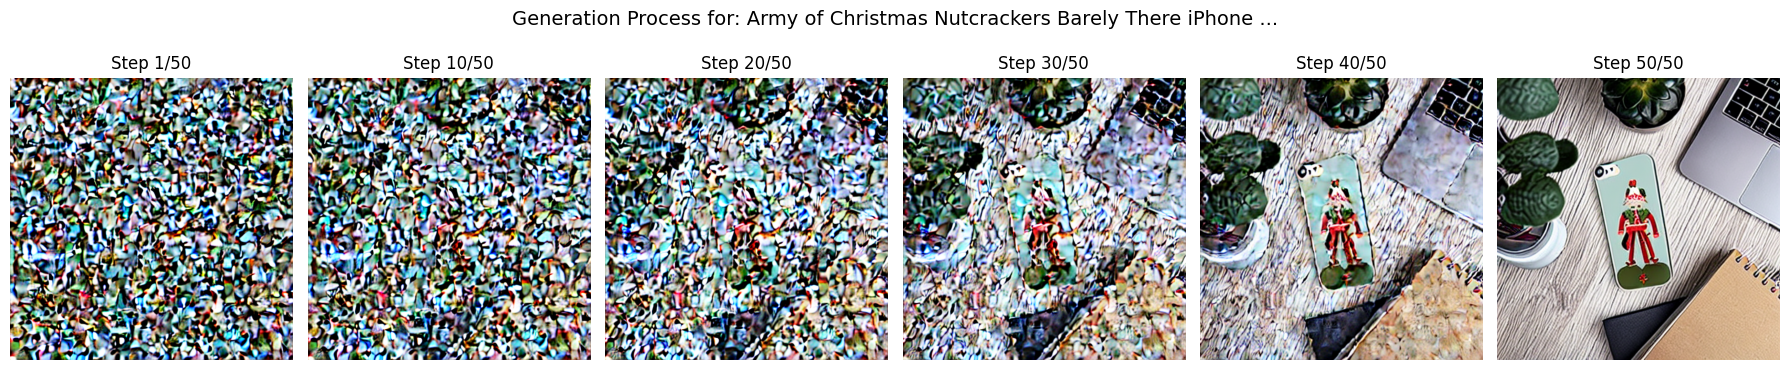

In [6]:
generator = torch.Generator(device=device).manual_seed(42)
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 64, 64),
    generator=generator,
    device=device,
    dtype=pipe.unet.dtype
)

# (C) Set Scheduler
pipe.scheduler.set_timesteps(50)
timesteps = pipe.scheduler.timesteps

# (D) Denoising Loop
intermediates = []
print("Starting denoising loop...")

for i, t in enumerate(timesteps):
    # 1. Expand latents for guidance (double the batch for uncond + cond)
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # 2. Predict Noise Residual
    with torch.no_grad():
        noise_pred = pipe.unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings_origin
        ).sample

    # 3. Perform Guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guidance_scale = 7.5
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 4. Compute Previous Noisy Sample x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # 5. Capture Intermediate Result (Decode to Image)
    # Decoding is expensive, so we do it every 10 steps or at specific checkpoints
    if i == 0 or (i + 1) % 10 == 0:
        with torch.no_grad():
            # Scale latents before decoding (SD v1.4 specific constant)
            latents_to_viz = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents_to_viz).sample
            # Rescale to [0, 1]
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            intermediates.append((i+1, image))

# 6. Visualize Steps
num_viz = len(intermediates)
fig, axes = plt.subplots(1, num_viz, figsize=(3*num_viz, 4))
plt.suptitle(f"Generation Process for: {target_prompt[:50]}...", fontsize=14)

for idx, (step, img) in enumerate(intermediates):
    if num_viz > 1:
        ax = axes[idx]
    else:
        ax = axes
    ax.imshow(img)
    ax.set_title(f"Step {step}/50")
    ax.axis("off")

plt.tight_layout()
plt.show()